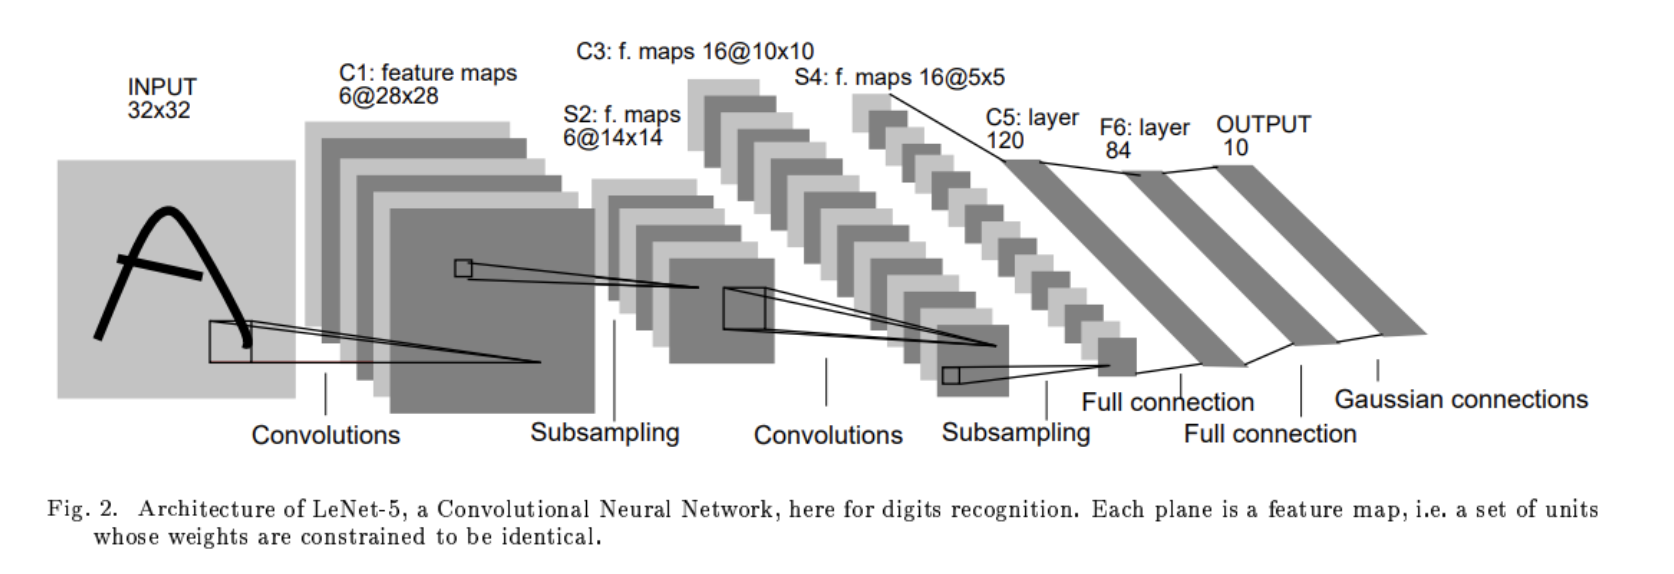

- **Reference**
    - https://www.researchgate.net/publication/344128059_Application_of_a_new_one-dimensional_deep_convolutional_neural_network_for_intelligent_fault_diagnosis_of_rolling_bearings/figures?lo=1&utm_source=google&utm_medium=organic
    - https://astonishing-antlion-13b.notion.site/A-Review-of-Convolutional-Neural-Networks-its-Variants-and-Applications-10fe61796c4280a586b5d2559e2f51a2
    - http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf

위 figure은 Yann LeCun 등이 저술한 **\<Gradient Based Learning Applied to Document Recognition\>** 논문에서 나온 LeNet-5 architecture structure이다. 위 figure를 보고 scratch부터 LeNet을 구현해보자.

저자는 여기서 character recognition, 즉 손으로 작성한 특정 글자를 제대로 인식하는 모델을 구현하기 위해 convolution layer를 단계적으로 배치하였다. LeNet의 architecture은 아래와 같이 구성되어 있다.

- **architecture**
    - 입력 → Conv 5 * 5
    - → stride 2인 subsampling을 2번 반복
        - **subsampling == pooling**
    - → Flatten (120 * 1 * 1)
    - → 2개의 Dense layer

In [87]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import skew
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import numpy as np
import scipy
from tqdm import tqdm

In [88]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from keras.utils import to_categorical

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D


---

In [89]:
# 각 데이터프레임의 column 이름

columns = ['age',
 'workclass',
 'fnlwgt',
 'education',
 'education-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country', 'target']

print (columns)

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'target']


In [90]:
# train data 파일, test data 파일 읽기

df_train = pd.read_csv("../../data/adult/adult_train.csv", names=columns)
df_test = pd.read_csv("../../data/adult/adult_test.csv", names=columns)

print (df_test.iloc[0]) # 1행은 전부 NaN으로 되어 있는 것을 확인. 
df_test.drop(0, inplace=True) 

print (df_train.head(2))
print (df_test.head(2))

age               |1x3 Cross validator
workclass                          NaN
fnlwgt                             NaN
education                          NaN
education-num                      NaN
marital-status                     NaN
occupation                         NaN
relationship                       NaN
race                               NaN
sex                                NaN
capital-gain                       NaN
capital-loss                       NaN
hours-per-week                     NaN
native-country                     NaN
target                             NaN
Name: 0, dtype: object
   age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   

        marital-status        occupation    relationship    race    sex  \
0        Never-married      Adm-clerical   Not-in-family   White   Male   
1   Married-civ-spouse   Exec-managerial         

In [91]:
# df의 기본적인 통계량 수치 파악, 각 열마다의 데이터 타입 

for feature in df_train.columns :
    print (f'df_train | {feature}의 데이터 타입 : ', df_train[feature].dtype)

for feature in df_test.columns :
    print (f'df_test | {feature}의 데이터 타입 : ', df_test[feature].dtype)   

df_train.describe()
df_test.describe()

df_train | age의 데이터 타입 :  int64
df_train | workclass의 데이터 타입 :  object
df_train | fnlwgt의 데이터 타입 :  int64
df_train | education의 데이터 타입 :  object
df_train | education-num의 데이터 타입 :  int64
df_train | marital-status의 데이터 타입 :  object
df_train | occupation의 데이터 타입 :  object
df_train | relationship의 데이터 타입 :  object
df_train | race의 데이터 타입 :  object
df_train | sex의 데이터 타입 :  object
df_train | capital-gain의 데이터 타입 :  int64
df_train | capital-loss의 데이터 타입 :  int64
df_train | hours-per-week의 데이터 타입 :  int64
df_train | native-country의 데이터 타입 :  object
df_train | target의 데이터 타입 :  object
df_test | age의 데이터 타입 :  object
df_test | workclass의 데이터 타입 :  object
df_test | fnlwgt의 데이터 타입 :  float64
df_test | education의 데이터 타입 :  object
df_test | education-num의 데이터 타입 :  float64
df_test | marital-status의 데이터 타입 :  object
df_test | occupation의 데이터 타입 :  object
df_test | relationship의 데이터 타입 :  object
df_test | race의 데이터 타입 :  object
df_test | sex의 데이터 타입 :  object
df_test | capital-gain의 데이터 타입 :  float6

,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,1.628100e+04,16281.000000,16281.000000,16281.000000,16281.000000
mean,1.894357e+05,10.072907,1081.905104,87.899269,40.392236
std,1.057149e+05,2.567545,7583.935968,403.105286,12.479332
min,1.349200e+04,1.000000,0.000000,0.000000,1.000000
25%,1.167360e+05,9.000000,0.000000,0.000000,40.000000
50%,1.778310e+05,10.000000,0.000000,0.000000,40.000000
75%,2.383840e+05,12.000000,0.000000,0.000000,45.000000
max,1.490400e+06,16.000000,99999.000000,3770.000000,99.000000


In [92]:
# ?이나, null이 포함된 record를 찾아서 제거

print(df_train.isnull().sum())
print()
print(df_test.isnull().sum())

print("Before preprocessing | ", df_train.shape, df_test.shape)

df_train = df_train.dropna() # 결측치 제거함
df_test = df_test.dropna()

# df_train_list = []
# df_test_list = []

# for ind in range(len(df_train)) : # ?가 들어간 record는 제외하여 list에 넣기
#     if not any(df_train[col].dtype == 'object' and '?' in str(df_train.at[ind, col]) for col in df_train.columns) :
#         df_train_list.append(df_train.loc[ind])

# for ind in range(len(df_test)) :
#     if not any(df_test[col].dtype == 'object' and '?' in str(df_test.at[ind, col]) for col in df_test.columns) :
#         df_test_list.append(df_test.loc[ind])

# df_train = pd.DataFrame(df_train_list) # 그 리스트로 다시 dataframe을 구성함
# df_test = pd.DataFrame(df_test_list)

df_train_list = []
df_test_list = []

for ind in range(len(df_train)) : # '?' 문자가 있는 행 제거 (iloc 사용)
    if not any(df_train[col].dtype == 'object' and '?' in str(df_train.iloc[ind][col]) for col in df_train.columns):
        df_train_list.append(df_train.iloc[ind])

for ind in range(len(df_test)) :
    if not any(df_test[col].dtype == 'object' and '?' in str(df_test.iloc[ind][col]) for col in df_test.columns):
        df_test_list.append(df_test.iloc[ind])

df_train = pd.DataFrame(df_train_list)
df_test = pd.DataFrame(df_test_list)

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

print("After preprocessing | ", df_train.shape, df_test.shape)

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
target            0
dtype: int64

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
target            0
dtype: int64
Before preprocessing |  (32561, 15) (16281, 15)
After preprocessing |  (30162, 15) (15060, 15)


In [93]:
# test 데이터 파일의 마지막 target 열의 온점을 모두 제거 (train과 통일성 위해)

for ind in range(df_test.shape[0]) :
    # 'target' 열의 마지막 문자가 온점인 경우 제거
    df_test.loc[ind, 'target'] = df_test.loc[ind, 'target'].rstrip('.')

In [94]:
# 문자열로 이루어진 범주형인 column을 모두 label encoding

from sklearn.preprocessing import LabelEncoder

for col in df_train.columns : 
    if df_train[col].dtype == "object" :
        print (f'{col} is object')
        l_e = LabelEncoder()
        
        df_train[col] = l_e.fit_transform(df_train[col])
        df_test[col] = l_e.transform(df_test[col])
        
df_train

workclass is object
education is object
marital-status is object
occupation is object
relationship is object
race is object
sex is object
native-country is object
target is object


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,5,77516,9,13,4,0,1,4,1,2174,0,40,38,0
1,50,4,83311,9,13,2,3,0,4,1,0,0,13,38,0
2,38,2,215646,11,9,0,5,1,4,1,0,0,40,38,0
3,53,2,234721,1,7,2,5,0,2,1,0,0,40,38,0
4,28,2,338409,9,13,2,9,5,2,0,0,0,40,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30157,27,2,257302,7,12,2,12,5,4,0,0,0,38,38,0
30158,40,2,154374,11,9,2,6,0,4,1,0,0,40,38,1
30159,58,2,151910,11,9,6,0,4,4,0,0,0,40,38,0
30160,22,2,201490,11,9,4,0,3,4,1,0,0,20,38,0


<Axes: xlabel='target', ylabel='count'>

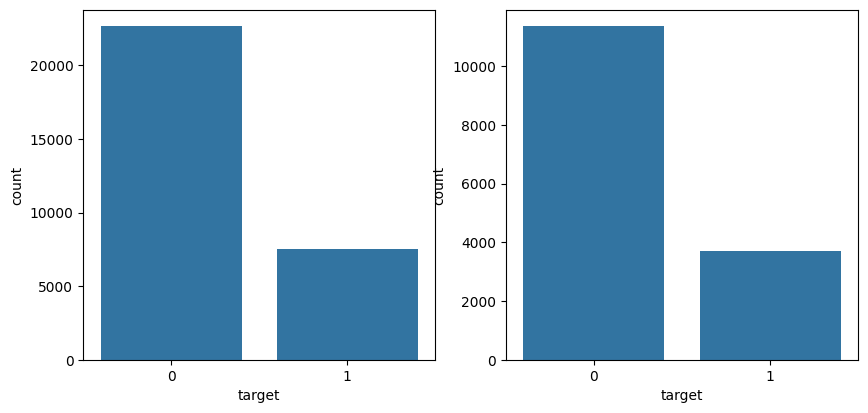

In [95]:
# target countplot 

# plt.subplot(221)
# sns.countplot(df_train['target'])

# plt.subplot(222)
# sns.countplot(df_test['target'])

plt.figure(figsize=(10, 10))

plt.subplot(221)
sns.countplot(data=df_train, x='target')

plt.subplot(222)
sns.countplot(data=df_test, x='target')

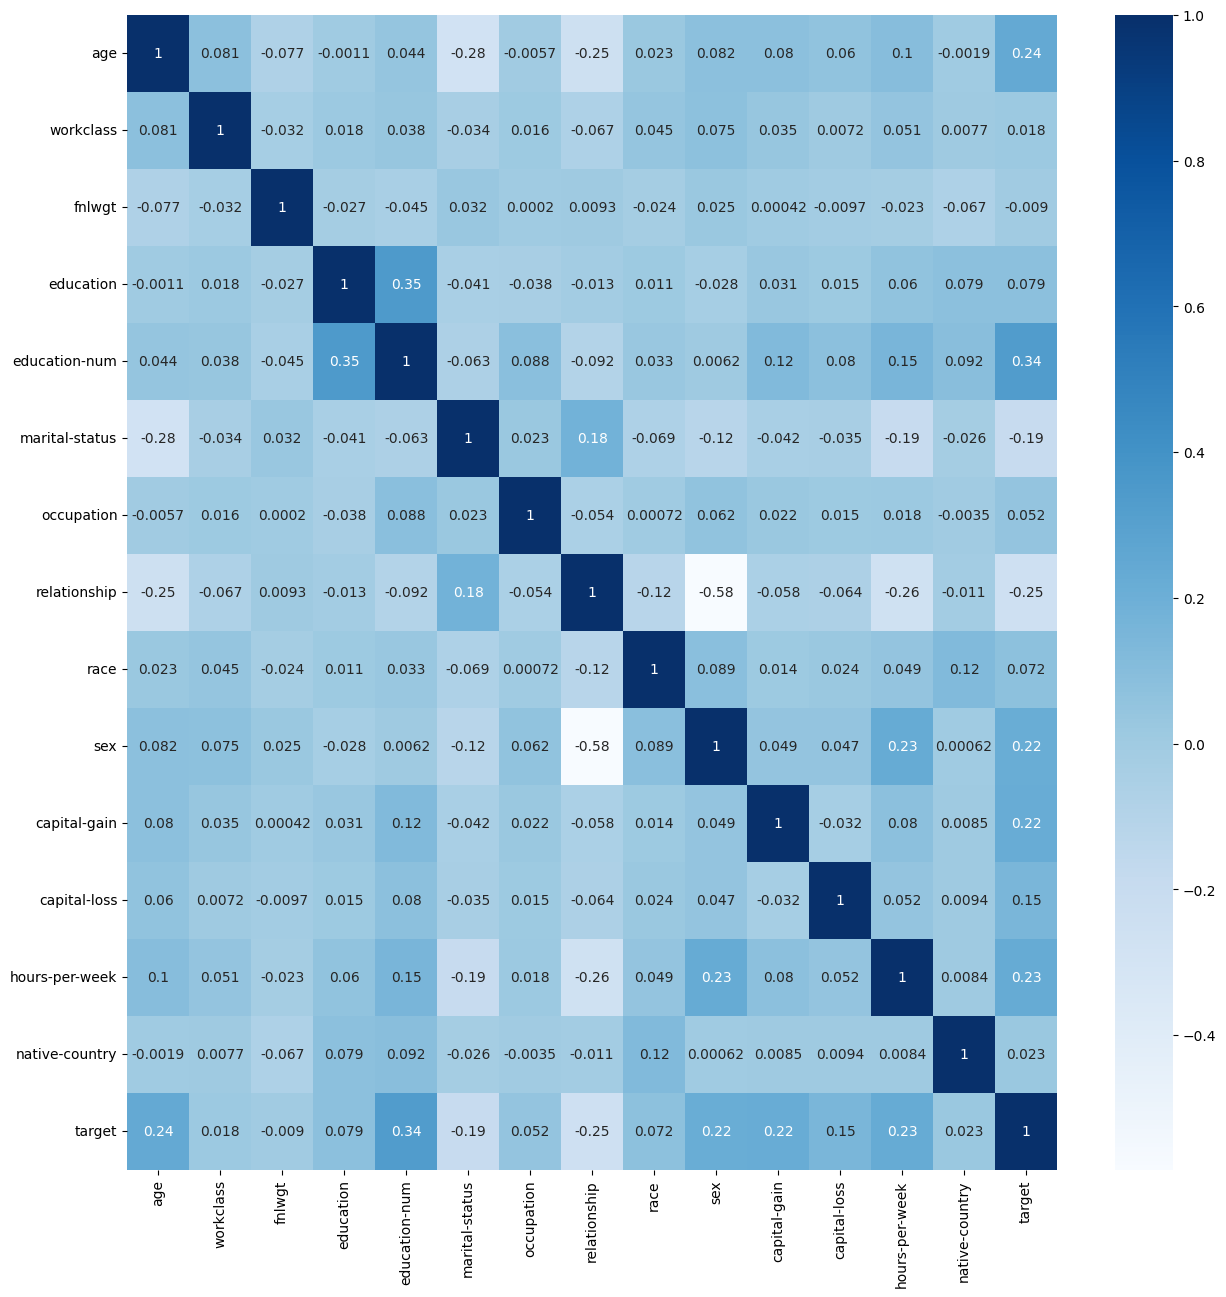

In [96]:
# heatmap 그리기 

'''
    train의 heatmap만 그린다. 
'''

plt.figure(figsize=(15, 15))

df_train_corr = df_train.corr()
sns.heatmap(df_train_corr, annot=True, cbar=True,
           cmap='Blues', annot_kws={"size": 10})
plt.show()

In [97]:
# train set, test set 합치기 -> oversampling

from sklearn.model_selection import train_test_split

df = pd.concat([df_train, df_test], axis=0)
adult_input = df.drop('target', axis=1)
adult_target = df['target']

In [98]:
# 각 열의 데이터 타입 확인

print(df.dtypes)

# age의 dtype을 int로 변경
df['age'] = df['age'].astype('int64')
print(df.dtypes)

age                object
workclass           int64
fnlwgt            float64
education           int64
education-num     float64
marital-status      int64
occupation          int64
relationship        int64
race                int64
sex                 int64
capital-gain      float64
capital-loss      float64
hours-per-week    float64
native-country      int64
target              int64
dtype: object
age                 int64
workclass           int64
fnlwgt            float64
education           int64
education-num     float64
marital-status      int64
occupation          int64
relationship        int64
race                int64
sex                 int64
capital-gain      float64
capital-loss      float64
hours-per-week    float64
native-country      int64
target              int64
dtype: object


In [99]:

'''
    oversampling과 undersampling을 함수로 구현한다. 
'''
    
def sampling(df, target_col, max_size) :
    # 결과를 저장할 리스트 
    dfs = []
    
    for label in df[target_col].unique() :
        class_df = df[df[target_col] == label]
        
        if len(class_df) < max_size :
            # 샘플 수가 max_size보다 적으면 데이터를 복제하여 max_size로 만듦
            sampled_df = class_df.sample(max_size, replace=True, random_state=42)
        else :
            # 샘플 수가 max_size보다 많으면 앞부분부터 max_size만큼 선택함
            sampled_df = class_df.head(max_size)
        
        # 리스트에 추가
        dfs.append(sampled_df)
    
    df_resampled = pd.concat(dfs).reset_index(drop=True)
    
    return df_resampled

df_resampled = sampling(df, 'target', max_size=10000)
print (df_resampled['target'].value_counts())

target
0    10000
1    10000
Name: count, dtype: int64


In [100]:
# input, target split

input_adult = df_resampled.drop('target', axis=1)
target_adult = df_resampled['target']

input_adult.shape, target_adult.shape

((20000, 14), (20000,))

In [101]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(input_adult,
                                                    target_adult,
                                                    stratify=target_adult,
                                                    test_size = 0.2, shuffle=True) 

# X_train, X_val, y_train, y_val = train_test_split(X_train,
#                                                     y_train,
#                                                     stratify=y_train,
#                                                     test_size = 0.2, shuffle=True) 

X_train.shape, X_test.shape

((16000, 14), (4000, 14))

In [102]:
'''
    순환 데이터를 구성하기 위하여 split_sequences를 사용하였다.
    이때, 각 window마다 class의 빈도 수를 측정하여 가장 많은 빈도수를 가진 class가 target이 되는 방식을 취하였다.
'''

from collections import Counter
import numpy as np

def split_sequences_freq(sequences, n_steps):
    X, y = list(), list()
    
    # Check if sequences is a DataFrame, convert if necessary
    if not isinstance(sequences, pd.DataFrame):
        sequences = pd.DataFrame(sequences)

    for i in range(len(sequences)):
        end_ix = i + n_steps

        if end_ix > len(sequences):
            break

        seq_x = sequences.iloc[i:end_ix, :-1].values
        seq_y = sequences.iloc[i:end_ix, -1].values   
        
        # Find the most frequent class in seq_y
        most_frequent_class = Counter(seq_y).most_common(1)[0][0]
        
        X.append(seq_x)
        y.append(int(most_frequent_class))

    return np.array(X), np.array(y)

In [103]:
# 순환 데이터 구성

train_set = np.c_[X_train, y_train]
test_set = np.c_[X_test, y_test]
# val_set = np.c_[X_val, y_val]

X_train_seq, y_train_seq = split_sequences_freq(train_set, 20) # 20개씩 묶기
print (X_train_seq)
print (y_train_seq)

print ("train : ", X_train_seq.shape, y_train_seq.shape)

X_test_seq, y_test_seq = split_sequences_freq(test_set, 20) # 20개씩 묶기
print (X_test_seq)
print (y_test_seq)

print ("test : ", X_test_seq.shape, y_test_seq.shape)

# X_val_seq, y_val_seq = split_sequences_freq(val_set, 20) # 20개씩 묶기
# print (X_val_seq)
# print (y_val_seq)

# print ("val : ", X_val_seq.shape, y_val_seq.shape)

[[[3.70000e+01 2.00000e+00 1.08913e+05 ... 0.00000e+00 4.00000e+01
   3.80000e+01]
  [2.30000e+01 2.00000e+00 1.60398e+05 ... 0.00000e+00 4.00000e+01
   3.80000e+01]
  [4.20000e+01 1.00000e+00 1.00793e+05 ... 0.00000e+00 6.00000e+01
   3.80000e+01]
  ...
  [4.10000e+01 2.00000e+00 1.16797e+05 ... 0.00000e+00 5.00000e+01
   3.80000e+01]
  [3.50000e+01 2.00000e+00 1.83898e+05 ... 0.00000e+00 5.00000e+01
   3.80000e+01]
  [4.70000e+01 4.00000e+00 1.31826e+05 ... 0.00000e+00 4.00000e+01
   3.80000e+01]]

 [[2.30000e+01 2.00000e+00 1.60398e+05 ... 0.00000e+00 4.00000e+01
   3.80000e+01]
  [4.20000e+01 1.00000e+00 1.00793e+05 ... 0.00000e+00 6.00000e+01
   3.80000e+01]
  [3.80000e+01 4.00000e+00 2.03836e+05 ... 0.00000e+00 4.00000e+01
   3.80000e+01]
  ...
  [3.50000e+01 2.00000e+00 1.83898e+05 ... 0.00000e+00 5.00000e+01
   3.80000e+01]
  [4.70000e+01 4.00000e+00 1.31826e+05 ... 0.00000e+00 4.00000e+01
   3.80000e+01]
  [2.60000e+01 1.00000e+00 1.66295e+05 ... 0.00000e+00 4.10000e+01
   3.8

In [104]:
# 실제로 어떻게 구성되었는지 X_train_seq와 y_train_seq의 앞쪽 5개의 component만 출력

print (np.isnan(y_train_seq).sum())

for idx in range (5) :
    print (f"X_train_seq[{idx}] : ", X_train_seq[idx][:5])
    print (f"y_train_seq[{idx}] : ", y_train_seq[idx])
    
    if idx == 0 : 
        prev = X_train_seq[idx]
        print()
        continue

    if (prev[1:] == X_train_seq[idx][:-1]).all() : 
        '''
            step 1씩 이동했으니깐, 이전 X_train_seq 원소의 2번째 record ~ 마지막번째 record와
            현재 X_train_seq 원소의 첫번째 record ~ 마지막-1번째 record는 같을 수밖에 없습니다.
        '''
         
        print ("window가 step 1씩 이동하면서 순환 데이터를 만듦")
    
    prev = X_train_seq[idx]
    print()

0
X_train_seq[0] :  [[3.70000e+01 2.00000e+00 1.08913e+05 1.10000e+01 9.00000e+00 4.00000e+00
  7.00000e+00 1.00000e+00 4.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00
  4.00000e+01 3.80000e+01]
 [2.30000e+01 2.00000e+00 1.60398e+05 1.50000e+01 1.00000e+01 3.00000e+00
  5.00000e+00 4.00000e+00 4.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00
  4.00000e+01 3.80000e+01]
 [4.20000e+01 1.00000e+00 1.00793e+05 9.00000e+00 1.30000e+01 2.00000e+00
  9.00000e+00 0.00000e+00 4.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00
  6.00000e+01 3.80000e+01]
 [3.80000e+01 4.00000e+00 2.03836e+05 4.00000e+00 3.00000e+00 4.00000e+00
  1.30000e+01 1.00000e+00 4.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00
  4.00000e+01 3.80000e+01]
 [3.50000e+01 2.00000e+00 2.00153e+05 1.20000e+01 1.40000e+01 2.00000e+00
  3.00000e+00 0.00000e+00 4.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00
  4.50000e+01 3.80000e+01]]
y_train_seq[0] :  1

X_train_seq[1] :  [[2.30000e+01 2.00000e+00 1.60398e+05 1.50000e+01 1.00000e+01 3.0

In [105]:
# one-hot encoding 

from tensorflow.keras.utils import to_categorical

y_train_seq_encoded = to_categorical(y_train_seq)
y_test_seq_encoded = to_categorical(y_test_seq)
# y_val_seq_encoded = to_categorical(y_val_seq)

print(y_train_seq[:5])  
print(y_train_seq_encoded[:5]) 

print(y_test_seq[:5])  
print(y_test_seq_encoded[:5])

# print(y_val_seq[:5])  
# print(y_val_seq_encoded[:5])

[1 1 1 0 1]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]
[0 0 0 0 0]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


----

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_19 (Conv1D)              │ (None, 16, 6)          │           426 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_15            │ (None, 8, 6)           │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 4, 16)          │           496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_16            │ (None, 2, 16)          │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 120)            │         3,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 2)              │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,216 (59.44 KB)

 Trainable params: 15,216 (59.44 KB)

 Non-trainable params: 0 (0.00 B)

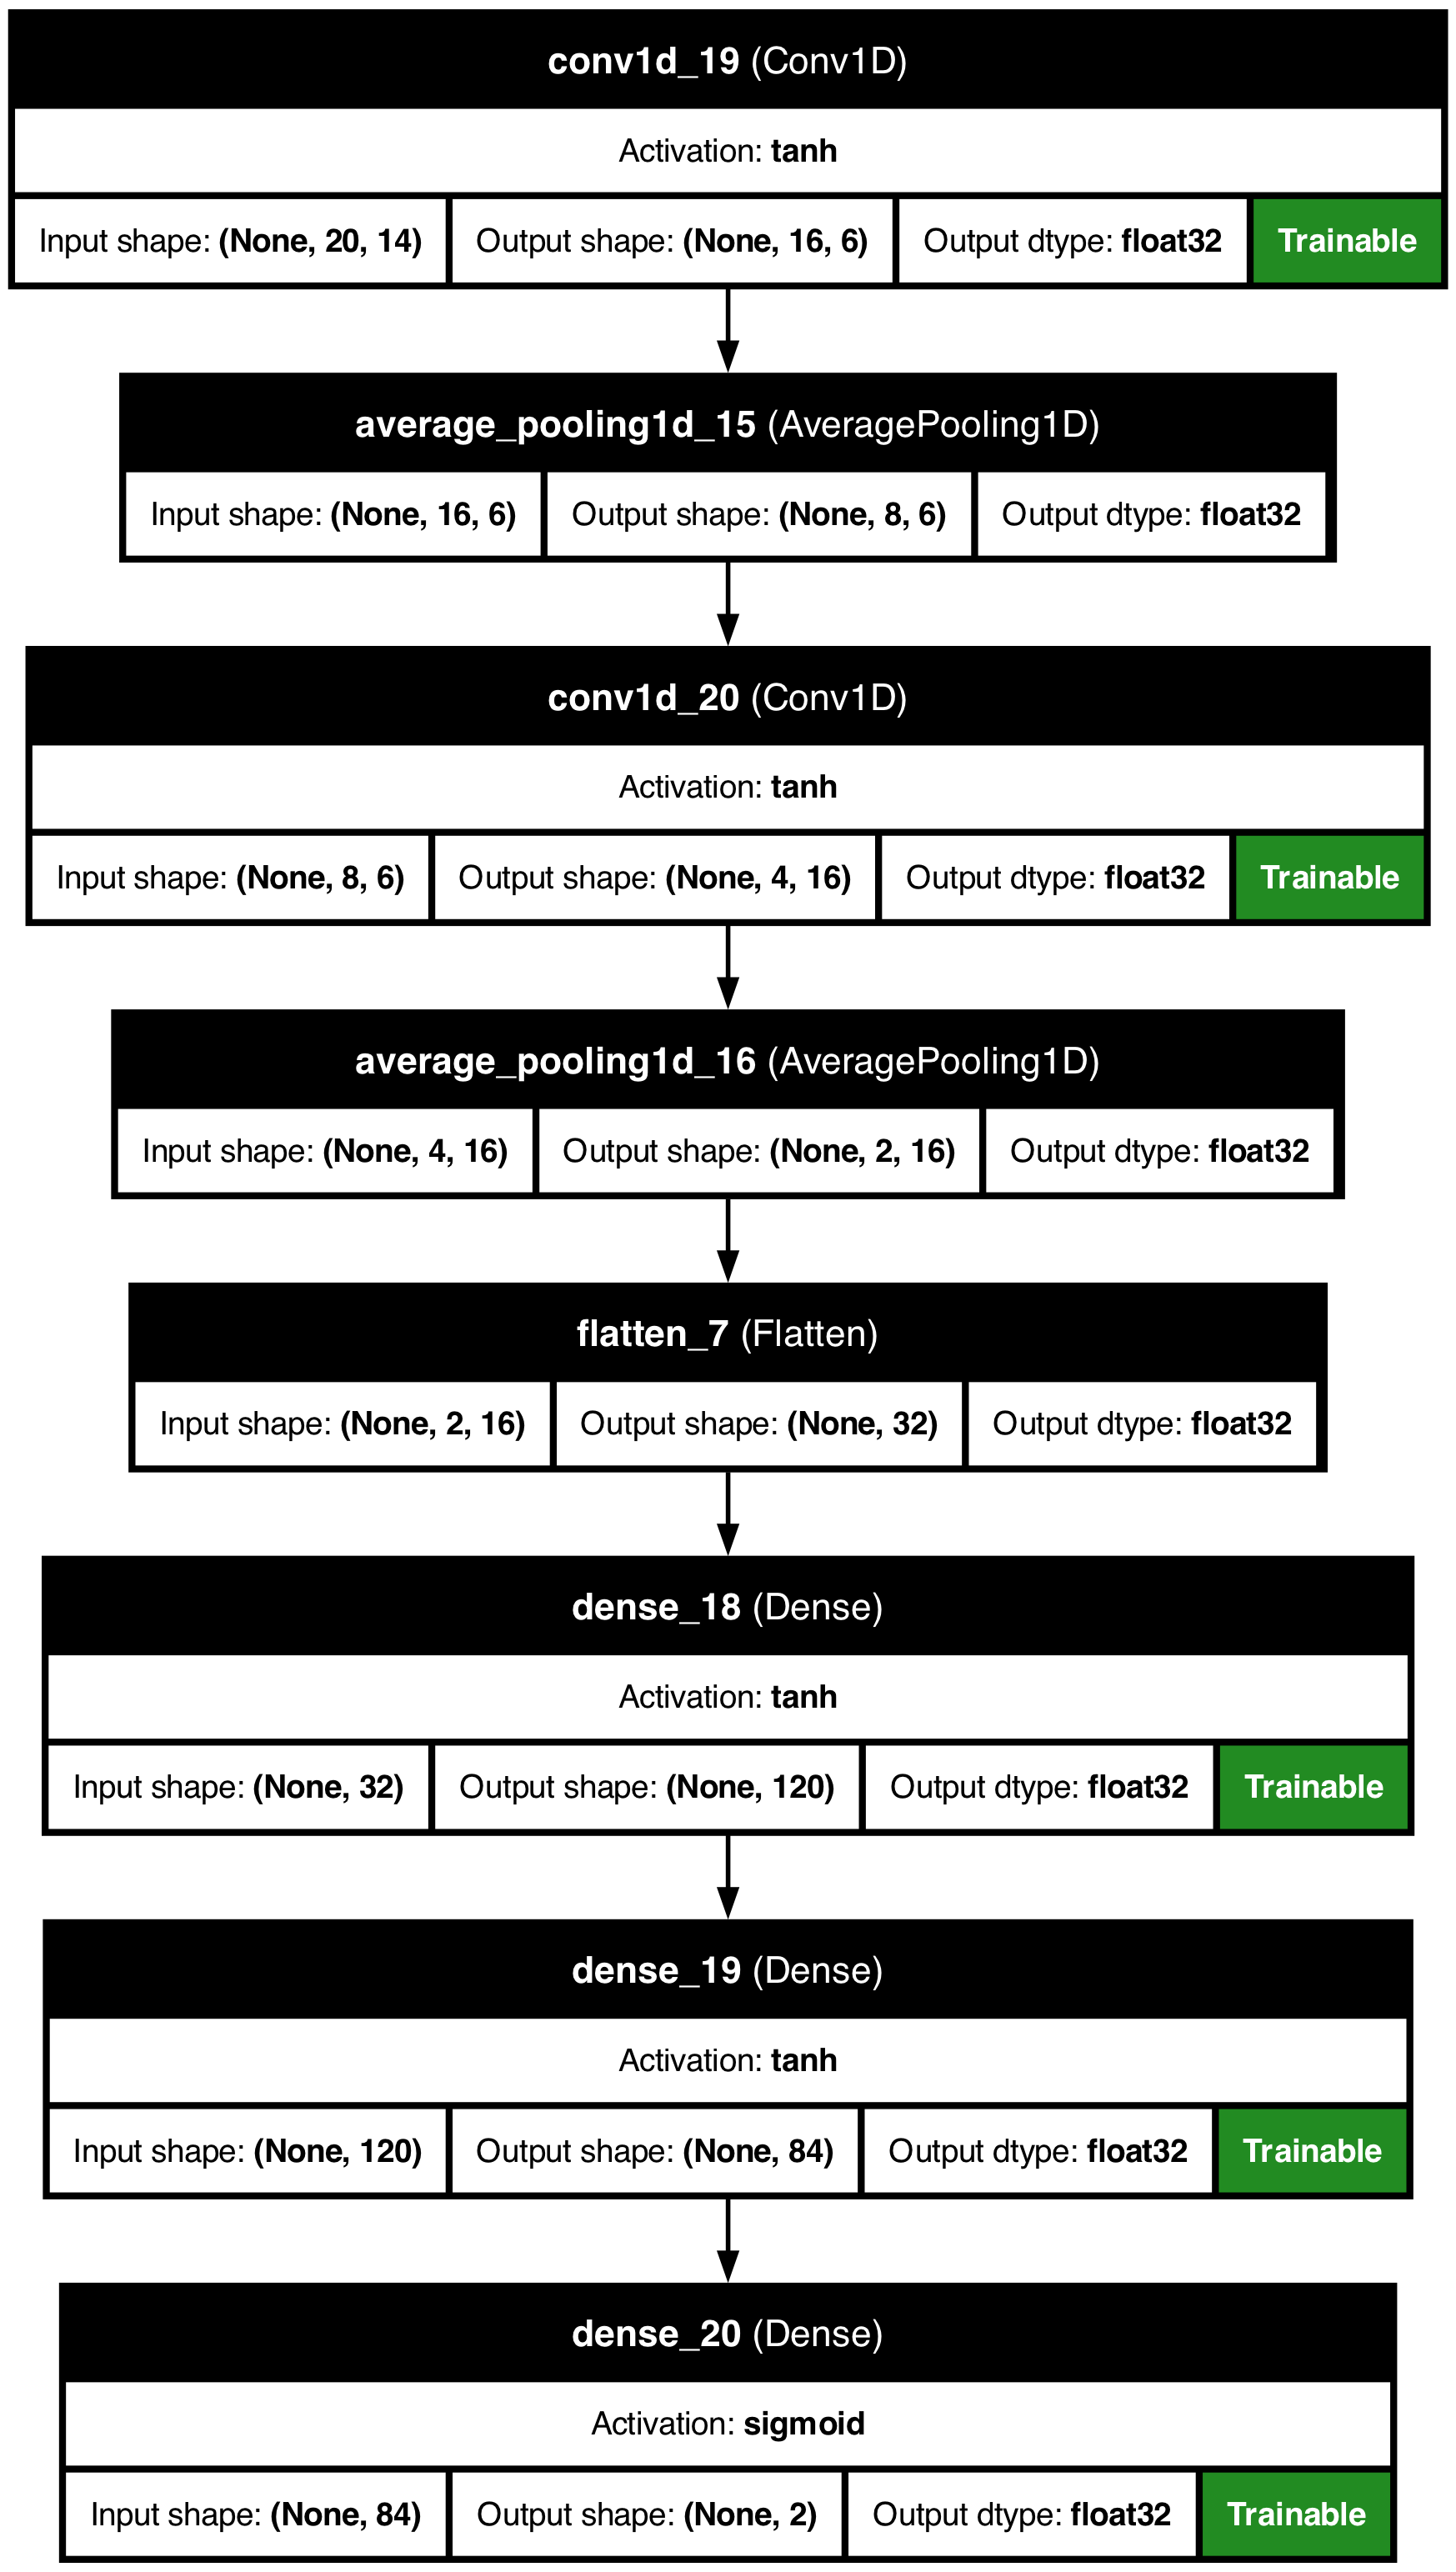

In [106]:
# modeling

'''
    위 LeNet 구조를 보았을 때, 
    convolution+pooling을 2번 반복한 후, Dense layer로 full connection block을 이루고 있다. 아래와 같이 modeling 가능하다.
'''

from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Input

def make_LeNet(input_shape) :
    model = Sequential()
    model.add(Input(shape=input_shape))  # Input 레이어 추가
    model.add(Conv1D(filters=6, kernel_size=5, strides=1, activation='tanh'))
    model.add(AvgPool1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=16, kernel_size=5, strides=1, activation='tanh'))
    model.add(AvgPool1D(pool_size=2, strides=2))
    model.add(Flatten())
    model.add(Dense(120, activation='tanh'))
    model.add(Dense(84, activation='tanh'))
    model.add(Dense(2, activation='sigmoid'))
    
    return model

LeNet = make_LeNet(input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]))

LeNet.summary()

plot_model(LeNet, 
           show_shapes=True, show_layer_activations=True, 
           show_dtype=True, show_layer_names=True, show_trainable=True)


In [107]:
# compile

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
LeNet.compile (optimizer=optimizer, 
               loss='binary_crossentropy', 
               metrics=['accuracy'])

In [108]:
# fit

from memory_profiler import profile

@profile # 메모리 오버플로우로 인한 시스템 다운을 막기 위해서
def train_model(model, X_train_seq, y_train_seq) :
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
    
    history = model.fit(X_train_seq, y_train_seq, epochs=100, 
                        validation_split=0.2,
                        batch_size=256,
                        callbacks=[early_stopping_cb], 
                        verbose=True, shuffle=True)
    
    return history

input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])  # (n_steps, 특징 수)
history = train_model(LeNet, X_train_seq, y_train_seq_encoded)

ERROR: Could not find file /var/folders/_z/gryfr07n59jgb3wrd062h1ym0000gn/T/ipykernel_61981/3729968759.py
Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5068 - loss: 0.7047 - val_accuracy: 0.4995 - val_loss: 0.6940
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5059 - loss: 0.6942 - val_accuracy: 0.4980 - val_loss: 0.6942
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5012 - loss: 0.6938 - val_accuracy: 0.4851 - val_loss: 0.6954
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5094 - loss: 0.6923 - val_accuracy: 0.4864 - val_loss: 0.6963
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5203 - loss: 0.6919 - val_accuracy: 0.4955 - val_loss: 0.6941
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5147 - loss: 0.6911 - val_accuracy: 0.4811 - val_loss: 0.6959
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5271 - loss: 0.6903 - val_accuracy: 0.4898 - val_loss: 0.6984
Epoc

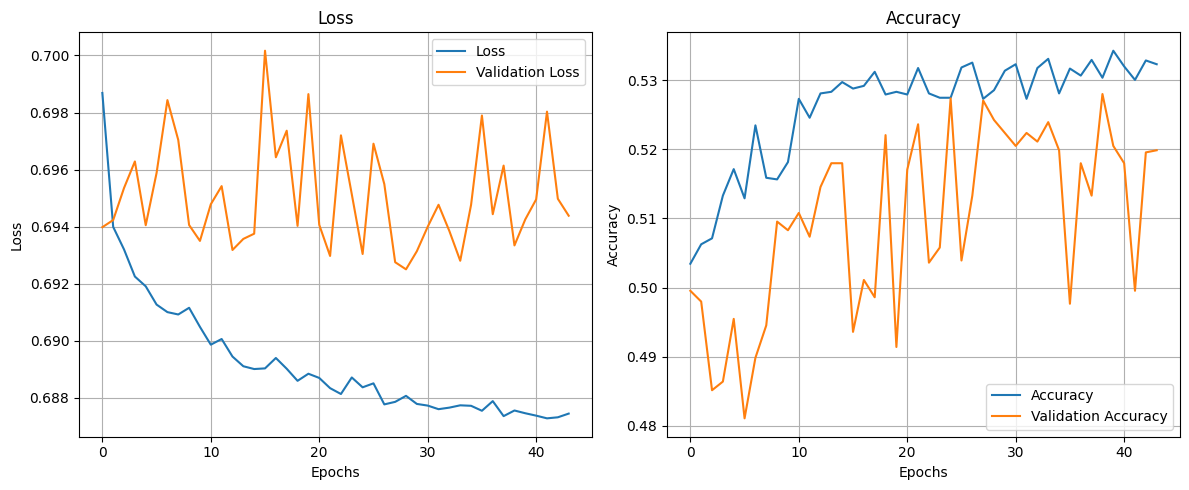

In [109]:
# loss와 validation loss, acc와 validation acc를 시각화하기 위한 메소드

def draw_history (history) :
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].plot(history.history['loss'], label='Loss')
    ax[0].plot(history.history['val_loss'], label='Validation Loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(history.history['accuracy'], label='Accuracy')
    ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    ax[1].grid()

    plt.tight_layout()
    plt.show()

draw_history(history)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Confusion Matrix


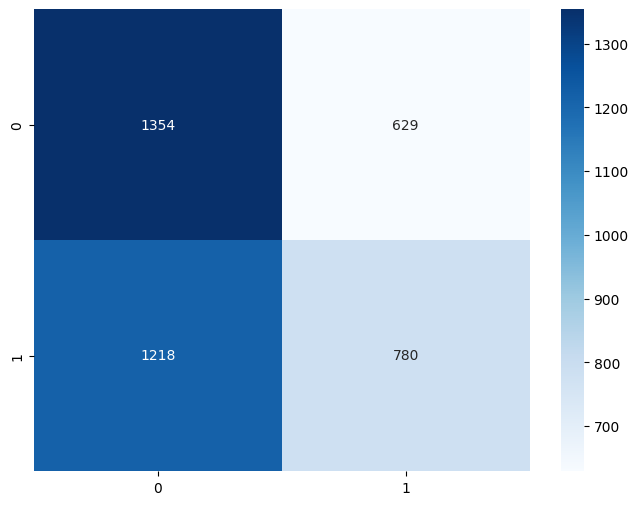

              precision    recall  f1-score   support

           0       0.53      0.68      0.59      1983
           1       0.55      0.39      0.46      1998

    accuracy                           0.54      3981
   macro avg       0.54      0.54      0.53      3981
weighted avg       0.54      0.54      0.53      3981



In [111]:
# confusion matrix, classification report, accuracy

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

y_test_arg = np.argmax(y_test_seq_encoded, axis=1)
Y_pred = np.argmax(LeNet.predict(X_test_seq),axis=1)
print ('Confusion Matrix')
cm = confusion_matrix(y_test_arg, Y_pred)

# confusion matrix 시각화
plt.figure(figsize=(8, 6))  # 그래프 크기 조절 (너비 8, 높이 6)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

# classification report
report = classification_report(y_test_arg, Y_pred)
print (report)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


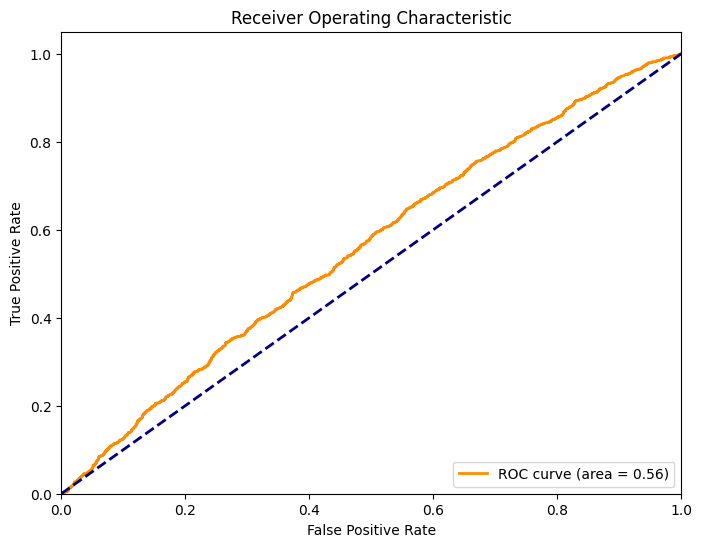

In [113]:
# ROC 시각화

from sklearn.metrics import roc_curve, roc_auc_score

y_test_pred_proba = LeNet.predict(X_test_seq)
fpr, tpr, thresholds = roc_curve(y_test_seq, y_test_pred_proba[:, 1])
roc_auc = roc_auc_score(y_test_seq, y_test_pred_proba[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [114]:
# evaluate

print ("train score : ", LeNet.evaluate(X_train_seq, y_train_seq_encoded))
print ("test score : ", LeNet.evaluate(X_test_seq, y_test_seq_encoded))

eval = LeNet.evaluate(X_test_seq, y_test_seq_encoded)

500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.5424 - loss: 0.6871
train score :  [0.6892884969711304, 0.5313810110092163]
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5207 - loss: 0.6940
test score :  [0.688805878162384, 0.5360462069511414]
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5207 - loss: 0.6940
